In [56]:
import os
import math
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
% matplotlib inline  
from PIL import Image
import cv2
from scipy.stats.kde import gaussian_kde
import h5py

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from tensorboardX import SummaryWriter

import logging
import imp
imp.reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S')

In [57]:
class MnistData():
    def __init__(self, batch_size=32, image_size=32, orig_image_size=64):
        self.name = 'mnist'
        self.load_mnist()
        
        self.batch_size = batch_size
        self.im_size = image_size
        self.orig_im_size = orig_image_size
        
        logging.info('number of training image: %d, number of testing image: %d', self.train_images.shape[0], 
                     self.test_images.shape[0])
    
    def load_mnist(self, file_name='/home/yi/code/video_motion_mnist/mnist.h5'):
        f = h5py.File(file_name)
        train_images = f['train'].value.reshape(-1, 28, 28)
        self.train_images = np.pad(train_images, ((0, 0), (2, 2), (2, 2)), 'constant')
        self.train_labels = f['train_labels'].value
        test_images = f['test'].value.reshape(-1, 28, 28)
        self.test_images = np.pad(test_images, ((0, 0), (2, 2), (2, 2)), 'constant')
        self.test_labels = f['test_labels'].value
    
    def get_next_batch(self, status='train'):
        batch_size, im_size, orig_im_size = self.batch_size, self.im_size, self.orig_im_size
        im = np.zeros((batch_size, im_size, im_size, 1))
        orig_im = np.zeros((batch_size, orig_im_size, orig_im_size, 1))
        direction = np.zeros((batch_size, 2))
        boxes = np.zeros((batch_size, 4))
        label = np.zeros(batch_size)
        
        if status == 'train':
            images = self.train_images
            labels = self.train_labels
        else:
            images = self.test_images
            labels = self.test_labels
        idx = np.random.permutation(images.shape[0])
        mnist_im = images[idx[0:batch_size], :, :]
        mnist_label = labels[idx[0:batch_size]]
        for i in range(batch_size):
            x = np.random.rand()
            y = np.random.rand()
            direction[i, 0] = x 
            direction[i, 1] = y
            x = int(x * im_size)
            y = int(y * im_size)
            orig_im[i, y:y+im_size, x:x+im_size, 0] = mnist_im[i, :, :]
            boxes[i, 0] = x
            boxes[i, 1] = y
            boxes[i, 2] = x + im_size
            boxes[i, 3] = y + im_size
            label[i] = mnist_label[i]
            im[i, :, :, 0] = cv2.resize(orig_im[i, :, :, 0], (im_size, im_size), interpolation=cv2.INTER_AREA)
        orig_im = orig_im.transpose((0, 3, 1, 2))
        im = im.transpose((0, 3, 1, 2))
        boxes = boxes * 1.0 / orig_im_size
        return im, orig_im, boxes, direction, label
    
    def display(self, im, orig_im, box, direction, label):
        print(direction[0, :], label[0])
        # Plot original large image with bounding box
        orig_im = orig_im[0, 0, :, :]
        fig, ax = plt.subplots(1)
        ax.imshow(orig_im, cmap='gray')
        
        b = box[0, 0:4].copy()
        im_height, im_width = orig_im.shape[0], orig_im.shape[1]
        b[0], b[1], b[2], b[3] = b[0] * im_width, b[1] * im_height, b[2] * im_width, b[3] * im_height
        print b
        rect = patches.Rectangle((b[0], b[1]), b[2] - 1 - b[0], b[3] - 1 - b[1], linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        plt.show()
        
        # Plot resized image with bounding box
        im = im[0, 0, :, :]
        fig, ax = plt.subplots(1)
        ax.imshow(im, cmap='gray')
        
        b = box[0, 0:4].copy()
        im_height, im_width = im.shape[0], im.shape[1]
        b[0], b[1], b[2], b[3] = b[0] * im_width, b[1] * im_height, b[2] * im_width, b[3] * im_height
        rect = patches.Rectangle((b[0], b[1]), b[2] - 1 - b[0], b[3] - 1 - b[1], linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        
        plt.show()

06:56:10 INFO:number of training image: 50000, number of testing image: 10000


(array([0.71825027, 0.47554899]), 1.0)
[22. 15. 54. 47.]


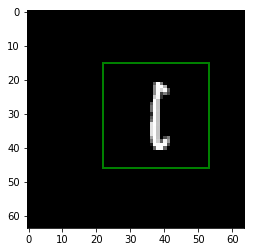

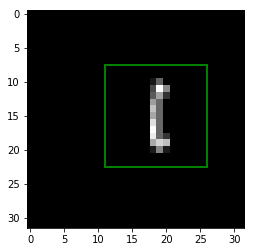

(array([0.41368595, 0.96658325]), 7.0)
[13. 30. 45. 62.]


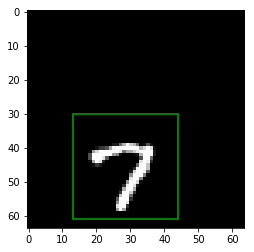

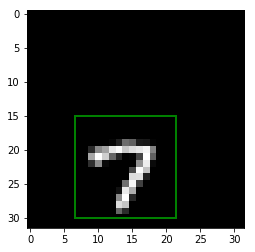

In [58]:
data = MnistData()
im, orig_im, box, direction, label = data.get_next_batch('train')
data.display(im, orig_im, box, direction, label)
im, orig_im, box, direction, label = data.get_next_batch('test')
data.display(im, orig_im, box, direction, label)

In [59]:
class BaseAttnDemo(object):
    def __init__(self, learning_rate, train_epoch, test_epoch, test_interval, test_all_epoch, save_interval, save_dir, 
                 batch_size, image_size, orig_image_size, attn_image_size, image_channel, num_class, 
                 tensorboard_path, init_model_path):
        logging.info('Baseline with bounding box crop estimated by image only demo')
        self.learning_rate = learning_rate
        self.train_epoch = train_epoch
        self.test_epoch = test_epoch
        self.test_interval = test_interval
        self.test_all_epoch = test_all_epoch
        self.save_interval = save_interval
        self.save_dir = save_dir
        self.best_test_acc = -1e10
        self.batch_size = batch_size
        self.im_size = image_size
        self.orig_im_size = orig_image_size
        self.attn_im_size = attn_image_size
        self.im_channel = image_channel
        self.n_class = num_class
        self.tensorboard_path = tensorboard_path
        self.init_model_path = init_model_path
        self.data = MnistData(batch_size, image_size, orig_image_size)
        self.model = self.init_model()

    def init_model(self):
        self.model = BaseAttnNet(self.batch_size, self.im_size, self.attn_im_size, self.im_channel, self.n_class)
        if torch.cuda.is_available():
            # model = torch.nn.DataParallel(model).cuda()
            self.model = self.model.cuda()
        if self.init_model_path is not '':
            self.model.load_state_dict(torch.load(self.init_model_path))
        return self.model

    def train(self):
        writer = SummaryWriter(self.tensorboard_path)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_loss_all, train_acc_all = [], []
        for epoch in range(self.train_epoch):
            optimizer.zero_grad()
            im, orig_im, box, direction, label = self.data.get_next_batch('train')
            im = Variable(torch.from_numpy(im).float())
            orig_im = Variable(torch.from_numpy(orig_im).float())
            direction = Variable(torch.from_numpy(direction).float())
            label = Variable(torch.from_numpy(label).long())
            if torch.cuda.is_available():
                im, orig_im, direction, label = im.cuda(), orig_im.cuda(), direction.cuda(), label.cuda()
            pred = self.model(im, orig_im)
            loss = criterion(pred, label)
            loss.backward()
            optimizer.step()

            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)
            
            writer.add_scalar('train_loss', loss.data[0], epoch)
            train_loss_all.append(loss.data[0])
            if len(train_loss_all) > 100:
                train_loss_all.pop(0)
            ave_train_loss = sum(train_loss_all) / float(len(train_loss_all))
            logging.info('epoch %d, train loss: %.2f, average train loss: %.2f', epoch, loss.data[0], ave_train_loss)
            writer.add_scalar('train_acc', acc, epoch)
            train_acc_all.append(acc)
            if len(train_acc_all) > 100:
                train_acc_all.pop(0)
            ave_train_acc = sum(train_acc_all) / float(len(train_acc_all))
            logging.info('epoch %d, train accuracy: %.2f, average train accuracy: %.2f', epoch, acc, ave_train_acc)
            if (epoch+1) % self.save_interval == 0:
                logging.info('epoch %d, saving model', epoch)
                with open(os.path.join(self.save_dir, '%d.pth' % epoch), 'w') as handle:
                    torch.save(self.model.state_dict(), handle)
            if (epoch+1) % self.test_interval == 0:
                logging.info('epoch %d, testing', epoch)
                test_loss, test_acc = self.validate()
                writer.add_scalar('test_loss', test_loss, epoch)
                writer.add_scalar('test_acc', test_acc, epoch)
        writer.close()

    def validate(self):
        test_loss, test_acc = self.test()
        if test_acc >= self.best_test_acc:
            logging.info('model save to %s', os.path.join(self.save_dir, 'model.pth'))
            with open(os.path.join(self.save_dir, 'model.pth'), 'w') as handle:
                torch.save(self.model.state_dict(), handle)
            self.best_test_acc = test_acc
        logging.info('current best test accuracy: %.2f', self.best_test_acc)
        return test_loss, test_acc

    def test(self):
        test_loss_all, test_acc_all = [], []
        criterion = nn.CrossEntropyLoss()
        for epoch in range(self.test_epoch):
            im, orig_im, box, direction, label = self.data.get_next_batch('test')
            im = Variable(torch.from_numpy(im).float(), volatile=True)
            orig_im = Variable(torch.from_numpy(orig_im).float(), volatile=True)
            direction = Variable(torch.from_numpy(direction).float(), volatile=True)
            label = Variable(torch.from_numpy(label).long(), volatile=True)
            if torch.cuda.is_available():
                im, orig_im, direction, label = im.cuda(), orig_im.cuda(), direction.cuda(), label.cuda()
            pred = self.model(im, orig_im)
            loss = criterion(pred, label)
            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)

            test_loss_all.append(loss.data[0])
            if len(test_loss_all) > 100:
                test_loss_all.pop(0)
            test_acc_all.append(acc)
            if len(test_acc_all) > 100:
                test_acc_all.pop(0)

        test_loss = np.mean(np.array(test_loss_all))
        test_acc = np.mean(np.array(test_acc_all))
        logging.info('average test loss: %.2f', test_loss)
        logging.info('average test accuracy: %.2f', test_acc)
        return test_loss, test_acc
    
    def test_all(self):
        test_loss_all, test_acc_all = [], []
        criterion = nn.CrossEntropyLoss()
        for epoch in range(self.test_all_epoch):
            im, orig_im, box, direction, label = self.data.get_next_batch('test')
            im = Variable(torch.from_numpy(im).float(), volatile=True)
            orig_im = Variable(torch.from_numpy(orig_im).float(), volatile=True)
            direction = Variable(torch.from_numpy(direction).float(), volatile=True)
            label = Variable(torch.from_numpy(label).long(), volatile=True)
            if torch.cuda.is_available():
                im, orig_im, direction, label = im.cuda(), orig_im.cuda(), direction.cuda(), label.cuda()
            pred = self.model(im, orig_im)
            loss = criterion(pred, label)
            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)
            test_loss_all.append(loss.data[0])
            test_acc_all.append(acc)

        test_loss = np.mean(np.array(test_loss_all))
        test_acc = np.mean(np.array(test_acc_all))
        logging.info('overall average test loss: %.2f', test_loss)
        logging.info('overall average test accuracy: %.2f', test_acc)
        
    def visualize(self, display=True):
        im, orig_im, box, direction, label = self.data.get_next_batch('test')
        im = Variable(torch.from_numpy(im).float(), volatile=True)
        orig_im = Variable(torch.from_numpy(orig_im).float(), volatile=True)
        direction = Variable(torch.from_numpy(direction).float(), volatile=True)
        label = Variable(torch.from_numpy(label).long(), volatile=True)
        if torch.cuda.is_available():
            im, orig_im, direction, label = im.cuda(), orig_im.cuda(), direction.cuda(), label.cuda()
        pred = self.model(im, orig_im, display)

In [60]:
class BaseAttnNet(nn.Module):
    def __init__(self, batch_size, im_size, attn_im_size, im_channel, n_class):
        super(BaseAttnNet, self).__init__()
        num_hidden = 16
        self.bn0 = nn.BatchNorm2d(im_channel)
        self.conv1 = nn.Conv2d(im_channel, num_hidden, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden*2, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(num_hidden*2)
        self.conv3 = nn.Conv2d(num_hidden*2, num_hidden*4, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(num_hidden*4)
        self.conv4 = nn.Conv2d(num_hidden*4, num_hidden*8, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(num_hidden*8)
        self.conv5 = nn.Conv2d(num_hidden*8, num_hidden*16, 3, 1, 1)
        self.bn5 = nn.BatchNorm2d(num_hidden*16)
        self.fc = nn.Linear(num_hidden*16, n_class)

        self.maxpool = nn.MaxPool2d(2, stride=2, return_indices=False, ceil_mode=False)

        self.bn_a0 = nn.BatchNorm2d(im_channel)
        self.conv_a1 = nn.Conv2d(im_channel, num_hidden, 3, 1, 1)
        self.bn_a1 = nn.BatchNorm2d(num_hidden)
        self.conv_a2 = nn.Conv2d(num_hidden, num_hidden*2, 3, 1, 1)
        self.bn_a2 = nn.BatchNorm2d(num_hidden*2)
        self.conv_a3 = nn.Conv2d(num_hidden*2, num_hidden*4, 3, 1, 1)
        self.bn_a3 = nn.BatchNorm2d(num_hidden*4)
        self.conv_a4 = nn.Conv2d(num_hidden*4, num_hidden*8, 3, 1, 1)
        self.bn_a4 = nn.BatchNorm2d(num_hidden*8)
        self.conv_a5 = nn.Conv2d(num_hidden*8, num_hidden*16, 3, 1, 1)
        self.bn_a5 = nn.BatchNorm2d(num_hidden*16)
        self.fc_a = nn.Linear(num_hidden*16, 2)
        
        grid = np.mgrid[0:im_size, 0:im_size]
        grid = np.tile(grid, [batch_size, 1, 1, 1])
        self.grid = Variable(torch.from_numpy(grid).float(), requires_grad=False)
        if torch.cuda.is_available():
            self.grid = self.grid.cuda()
        
        self.batch_size = batch_size
        self.im_size = im_size
        self.attn_im_size = attn_im_size

    def stn(self, im):
        x = self.bn_a0(im)
        x1 = F.relu(self.bn_a1(self.conv_a1(x)))
        x2 = self.maxpool(x1)
        x2 = F.relu(self.bn_a2(self.conv_a2(x2)))
        x3 = self.maxpool(x2)
        x3 = F.relu(self.bn_a3(self.conv_a3(x3)))
        x4 = self.maxpool(x3)
        x4 = F.relu(self.bn_a4(self.conv_a4(x4)))
        x5 = self.maxpool(x4)
        x5 = F.relu(self.bn_a5(self.conv_a5(x5)))
        x = self.maxpool(x5)
        x = x.view(x.size(0), -1)
        box = self.fc_a(x)
        return box
        
    def crop_image(self, im, box):
        # Adjust box scale w.r.t. an image in the coordinate system [-1, 1] for spatial transformer usage
        box = F.sigmoid(box)
        boxes = Variable(torch.zeros(self.batch_size, 4))
        if torch.cuda.is_available():
            boxes = boxes.cuda()
        boxes[:, 0] = box[:, 0] - 0.25
        boxes[:, 1] = box[:, 1] - 0.25
        boxes[:, 2] = box[:, 0] + 0.25
        boxes[:, 3] = box[:, 1] + 0.25
        boxes = F.relu(boxes)
        boxes = 1 - F.relu(1 - boxes)
        bb = boxes * 2 - 1
        # Compute the sampling distance for every pixel in the box
        sample_dist_x = (bb[:, 2] - bb[:, 0]) / self.attn_im_size
        sample_dist_y = (bb[:, 3] - bb[:, 1]) / self.attn_im_size
        start_x = bb[:, 0]
        start_y = bb[:, 1]
        
        grid_x = self.grid[:, 1, :, :] * sample_dist_x[:, None, None] + start_x[:, None, None]
        grid_y = self.grid[:, 0, :, :] * sample_dist_y[:, None, None] + start_y[:, None, None]
        grid = torch.stack((grid_x, grid_y), 3)       
        
        crop_im = F.grid_sample(im, grid)
        return crop_im, boxes
        
    def forward(self, im, orig_im, display=False):
        box = self.stn(im)
        # predict using attention area from spatial transformer network on high resolution image second
        crop_im, boxes = self.crop_image(orig_im, box)
        if display:
            self.show_box(orig_im, boxes, crop_im)    
        x = self.bn0(crop_im)
        x1 = F.relu(self.bn1(self.conv1(x)))
        x2 = self.maxpool(x1)
        x2 = F.relu(self.bn2(self.conv2(x2)))
        x3 = self.maxpool(x2)
        x3 = F.relu(self.bn3(self.conv3(x3)))
        x4 = self.maxpool(x3)
        x4 = F.relu(self.bn4(self.conv4(x4)))
        x5 = self.maxpool(x4)
        x5 = F.relu(self.bn5(self.conv5(x5)))
        x = self.maxpool(x5)
        x = x.view(x.size(0), -1)
        pred = self.fc(x)
        return pred
    
    def show_box(self, im, box, crop_im):
        im = im.cpu().data.numpy()
        im = im[0, 0, :, :]
        
        fig, ax = plt.subplots(1)
        ax.imshow(im, cmap='gray')

        box = box.cpu().data.numpy()
        b = box[0, 0:4].copy()
        im_height, im_width = im.shape[0], im.shape[1]
        b[0], b[1], b[2], b[3] = b[0] * im_width, b[1] * im_height, b[2] * im_width, b[3] * im_height
        rect = patches.Rectangle((b[0], b[1]), b[2] - 1 - b[0], b[3] - 1 - b[1], linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        
        print(box[0, :])
        
        crop_im = crop_im.cpu().data.numpy()
        crop_im = crop_im[0, 0, :, :]
        fig, ax = plt.subplots(1)
        ax.imshow(crop_im, cmap='gray')
        plt.show()

06:56:12 INFO:Baseline with bounding box crop estimated by image only demo
06:56:13 INFO:number of training image: 50000, number of testing image: 10000
06:56:13 INFO:epoch 0, train loss: 2.40, average train loss: 2.40
06:56:13 INFO:epoch 0, train accuracy: 0.03, average train accuracy: 0.03
06:56:13 INFO:epoch 1, train loss: 2.44, average train loss: 2.42
06:56:13 INFO:epoch 1, train accuracy: 0.11, average train accuracy: 0.07
06:56:13 INFO:epoch 2, train loss: 2.37, average train loss: 2.40
06:56:13 INFO:epoch 2, train accuracy: 0.06, average train accuracy: 0.07
06:56:13 INFO:epoch 3, train loss: 2.41, average train loss: 2.41
06:56:13 INFO:epoch 3, train accuracy: 0.09, average train accuracy: 0.07
06:56:13 INFO:epoch 4, train loss: 2.37, average train loss: 2.40
06:56:13 INFO:epoch 4, train accuracy: 0.14, average train accuracy: 0.09
06:56:13 INFO:epoch 5, train loss: 2.32, average train loss: 2.39
06:56:13 INFO:epoch 5, train accuracy: 0.11, average train accuracy: 0.09
06:56:1

[0.49019086 0.09999853 0.99019086 0.59999853]


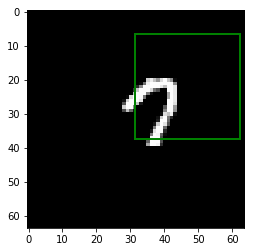

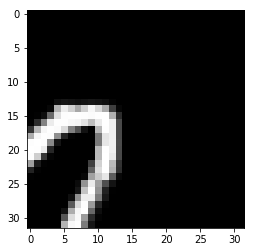

In [61]:
command = 'train'

learning_rate = 1e-3
train_epoch = 1000
test_epoch = 10
test_interval = 100
test_all_epoch = 1000
save_interval = 1001
save_dir = './'
batch_size = 64
im_size = 32
orig_im_size = 64
attn_im_size = 32
im_channel = 1
n_class = 10
tensorboard_path = './tensorboard/mnist_base_attn'
init_model_path = ''
demo = BaseAttnDemo(learning_rate, train_epoch, test_epoch, test_interval, test_all_epoch, save_interval, save_dir, 
                    batch_size, im_size, orig_im_size, attn_im_size, im_channel, n_class, tensorboard_path, 
                    init_model_path)
if command == 'train':
    demo.train()
elif command == 'test':
    demo.test()
    
demo.test_all()
demo.visualize()

[0.53768194 0.23554862 1.         0.7355486 ]


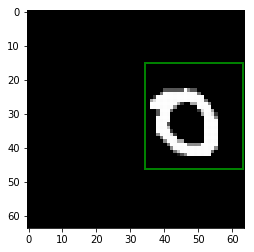

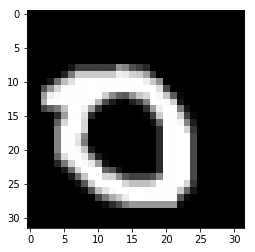

In [62]:
demo.visualize()

In [63]:
class BaseDirectionAttnDemo(object):
    def __init__(self, learning_rate, train_epoch, test_epoch, test_interval, test_all_epoch, save_interval, save_dir, 
                 batch_size, image_size, orig_image_size, attn_image_size, image_channel, direction_dim, num_class, 
                 tensorboard_path, init_model_path):
        logging.info('Baseline with bounding box crop estimated by direction only demo')
        self.learning_rate = learning_rate
        self.train_epoch = train_epoch
        self.test_epoch = test_epoch
        self.test_interval = test_interval
        self.test_all_epoch = test_all_epoch
        self.save_interval = save_interval
        self.save_dir = save_dir
        self.best_test_acc = -1e10
        self.batch_size = batch_size
        self.im_size = image_size
        self.orig_im_size = orig_image_size
        self.attn_im_size = attn_image_size
        self.im_channel = image_channel
        self.direction_dim = direction_dim
        self.n_class = num_class
        self.tensorboard_path = tensorboard_path
        self.init_model_path = init_model_path
        self.data = MnistData(batch_size, image_size, orig_image_size)
        self.model = self.init_model()

    def init_model(self):
        self.model = BaseDirectionAttnNet(self.batch_size, self.im_size, self.attn_im_size, self.im_channel, 
                                          self.direction_dim, self.n_class)
        if torch.cuda.is_available():
            # model = torch.nn.DataParallel(model).cuda()
            self.model = self.model.cuda()
        if self.init_model_path is not '':
            self.model.load_state_dict(torch.load(self.init_model_path))
        return self.model

    def train(self):
        writer = SummaryWriter(self.tensorboard_path)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_loss_all, train_acc_all = [], []
        for epoch in range(self.train_epoch):
            optimizer.zero_grad()
            im, orig_im, box, direction, label = self.data.get_next_batch('train')
            orig_im = Variable(torch.from_numpy(orig_im).float())
            direction = Variable(torch.from_numpy(direction).float())
            label = Variable(torch.from_numpy(label).long())
            if torch.cuda.is_available():
                orig_im, direction, label = orig_im.cuda(), direction.cuda(), label.cuda()
            pred = self.model(orig_im, direction)
            loss = criterion(pred, label)
            loss.backward()
            optimizer.step()

            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)
            
            writer.add_scalar('train_loss', loss.data[0], epoch)
            train_loss_all.append(loss.data[0])
            if len(train_loss_all) > 100:
                train_loss_all.pop(0)
            ave_train_loss = sum(train_loss_all) / float(len(train_loss_all))
            logging.info('epoch %d, train loss: %.2f, average train loss: %.2f', epoch, loss.data[0], ave_train_loss)
            writer.add_scalar('train_acc', acc, epoch)
            train_acc_all.append(acc)
            if len(train_acc_all) > 100:
                train_acc_all.pop(0)
            ave_train_acc = sum(train_acc_all) / float(len(train_acc_all))
            logging.info('epoch %d, train accuracy: %.2f, average train accuracy: %.2f', epoch, acc, ave_train_acc)
            if (epoch+1) % self.save_interval == 0:
                logging.info('epoch %d, saving model', epoch)
                with open(os.path.join(self.save_dir, '%d.pth' % epoch), 'w') as handle:
                    torch.save(self.model.state_dict(), handle)
            if (epoch+1) % self.test_interval == 0:
                logging.info('epoch %d, testing', epoch)
                test_loss, test_acc = self.validate()
                writer.add_scalar('test_loss', test_loss, epoch)
                writer.add_scalar('test_acc', test_acc, epoch)
        writer.close()

    def validate(self):
        test_loss, test_acc = self.test()
        if test_acc >= self.best_test_acc:
            logging.info('model save to %s', os.path.join(self.save_dir, 'model.pth'))
            with open(os.path.join(self.save_dir, 'model.pth'), 'w') as handle:
                torch.save(self.model.state_dict(), handle)
            self.best_test_acc = test_acc
        logging.info('current best test accuracy: %.2f', self.best_test_acc)
        return test_loss, test_acc

    def test(self):
        test_loss_all, test_acc_all = [], []
        criterion = nn.CrossEntropyLoss()
        for epoch in range(self.test_epoch):
            im, orig_im, box, direction, label = self.data.get_next_batch('test')
            orig_im = Variable(torch.from_numpy(orig_im).float(), volatile=True)
            direction = Variable(torch.from_numpy(direction).float(), volatile=True)
            label = Variable(torch.from_numpy(label).long(), volatile=True)
            if torch.cuda.is_available():
                orig_im, direction, label = orig_im.cuda(), direction.cuda(), label.cuda()
            pred = self.model(orig_im, direction)
            loss = criterion(pred, label)
            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)

            test_loss_all.append(loss.data[0])
            if len(test_loss_all) > 100:
                test_loss_all.pop(0)
            test_acc_all.append(acc)
            if len(test_acc_all) > 100:
                test_acc_all.pop(0)

        test_loss = np.mean(np.array(test_loss_all))
        test_acc = np.mean(np.array(test_acc_all))
        logging.info('average test loss: %.2f', test_loss)
        logging.info('average test accuracy: %.2f', test_acc)
        return test_loss, test_acc
    
    def test_all(self):
        test_loss_all, test_acc_all = [], []
        criterion = nn.CrossEntropyLoss()
        for epoch in range(self.test_all_epoch):
            im, orig_im, box, direction, label = self.data.get_next_batch('test')
            orig_im = Variable(torch.from_numpy(orig_im).float(), volatile=True)
            direction = Variable(torch.from_numpy(direction).float(), volatile=True)
            label = Variable(torch.from_numpy(label).long(), volatile=True)
            if torch.cuda.is_available():
                orig_im, direction, label = orig_im.cuda(), direction.cuda(), label.cuda()
            pred = self.model(orig_im, direction)
            loss = criterion(pred, label)
            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)
            test_loss_all.append(loss.data[0])
            test_acc_all.append(acc)

        test_loss = np.mean(np.array(test_loss_all))
        test_acc = np.mean(np.array(test_acc_all))
        logging.info('overall average test loss: %.2f', test_loss)
        logging.info('overall average test accuracy: %.2f', test_acc)
        
    def visualize(self, display=True):
        im, orig_im, box, direction, label = self.data.get_next_batch('test')
        orig_im = Variable(torch.from_numpy(orig_im).float(), volatile=True)
        direction = Variable(torch.from_numpy(direction).float(), volatile=True)
        label = Variable(torch.from_numpy(label).long(), volatile=True)
        if torch.cuda.is_available():
            orig_im, direction, label = orig_im.cuda(), direction.cuda(), label.cuda()
        pred = self.model(orig_im, direction, display)

In [ ]:
class BaseDirectionAttnNet(nn.Module):
    def __init__(self, batch_size, im_size, attn_im_size, im_channel, direction_dim, n_class):
        super(BaseDirectionAttnNet, self).__init__()
        num_hidden = 16
        self.bn0 = nn.BatchNorm2d(im_channel)
        self.conv1 = nn.Conv2d(im_channel, num_hidden, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden*2, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(num_hidden*2)
        self.conv3 = nn.Conv2d(num_hidden*2, num_hidden*4, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(num_hidden*4)
        self.conv4 = nn.Conv2d(num_hidden*4, num_hidden*8, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(num_hidden*8)
        self.conv5 = nn.Conv2d(num_hidden*8, num_hidden*16, 3, 1, 1)
        self.bn5 = nn.BatchNorm2d(num_hidden*16)
        self.fc = nn.Linear(num_hidden*16, n_class)

        self.maxpool = nn.MaxPool2d(2, stride=2, return_indices=False, ceil_mode=False)

        self.bn_d0 = nn.BatchNorm1d(direction_dim)
        self.fc_box = nn.Linear(direction_dim, 2)
        
        grid = np.mgrid[0:im_size, 0:im_size]
        grid = np.tile(grid, [batch_size, 1, 1, 1])
        self.grid = Variable(torch.from_numpy(grid).float(), requires_grad=False)
        if torch.cuda.is_available():
            self.grid = self.grid.cuda()
        
        self.batch_size = batch_size
        self.im_size = im_size
        self.attn_im_size = attn_im_size

    def stn(self, direction):
        # d0 = self.bn_d0(direction)
        # box = self.fc_box(d0)
        box = self.fc_box(direction)
        return box
        
    def crop_image(self, im, box):
        # Adjust box scale w.r.t. an image in the coordinate system [-1, 1] for spatial transformer usage
        box = F.sigmoid(box)
        boxes = Variable(torch.zeros(self.batch_size, 4))
        if torch.cuda.is_available():
            boxes = boxes.cuda()
        boxes[:, 0] = box[:, 0] - 0.25
        boxes[:, 1] = box[:, 1] - 0.25
        boxes[:, 2] = box[:, 0] + 0.25
        boxes[:, 3] = box[:, 1] + 0.25
        boxes = F.relu(boxes)
        boxes = 1 - F.relu(1 - boxes)
        bb = boxes * 2 - 1
        # Compute the sampling distance for every pixel in the box
        sample_dist_x = (bb[:, 2] - bb[:, 0]) / self.attn_im_size
        sample_dist_y = (bb[:, 3] - bb[:, 1]) / self.attn_im_size
        start_x = bb[:, 0]
        start_y = bb[:, 1]
        
        grid_x = self.grid[:, 1, :, :] * sample_dist_x[:, None, None] + start_x[:, None, None]
        grid_y = self.grid[:, 0, :, :] * sample_dist_y[:, None, None] + start_y[:, None, None]
        grid = torch.stack((grid_x, grid_y), 3)       
        
        crop_im = F.grid_sample(im, grid)
        return crop_im, boxes
        
    def forward(self, orig_im, direction, display=False):
        box = self.stn(direction)
        # predict using attention area from spatial transformer network on high resolution image second
        crop_im, boxes = self.crop_image(orig_im, box)
        if display:
            self.show_box(orig_im, boxes, direction, crop_im)    
        x = self.bn0(crop_im)
        x1 = F.relu(self.bn1(self.conv1(x)))
        x2 = self.maxpool(x1)
        x2 = F.relu(self.bn2(self.conv2(x2)))
        x3 = self.maxpool(x2)
        x3 = F.relu(self.bn3(self.conv3(x3)))
        x4 = self.maxpool(x3)
        x4 = F.relu(self.bn4(self.conv4(x4)))
        x5 = self.maxpool(x4)
        x5 = F.relu(self.bn5(self.conv5(x5)))
        x = self.maxpool(x5)
        x = x.view(x.size(0), -1)
        pred = self.fc(x)
        return pred
    
    def show_box(self, im, box, direction, crop_im):
        im = im.cpu().data.numpy()
        im = im[0, 0, :, :]
        
        fig, ax = plt.subplots(1)
        ax.imshow(im, cmap='gray')

        box = box.cpu().data.numpy()
        b = box[0, 0:4].copy()
        im_height, im_width = im.shape[0], im.shape[1]
        b[0], b[1], b[2], b[3] = b[0] * im_width, b[1] * im_height, b[2] * im_width, b[3] * im_height
        rect = patches.Rectangle((b[0], b[1]), b[2] - 1 - b[0], b[3] - 1 - b[1], linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
                
        direction = direction.cpu().data.numpy()
        direction = direction[0, :]
        print(direction, box[0, :])
        
        crop_im = crop_im.cpu().data.numpy()
        crop_im = crop_im[0, 0, :, :]
        fig, ax = plt.subplots(1)
        ax.imshow(crop_im, cmap='gray')
        plt.show()

In [ ]:
command = 'train'

learning_rate = 1e-3
train_epoch = 2000
test_epoch = 10
test_interval = 100
test_all_epoch = 1000
save_interval = 1001
save_dir = './'
batch_size = 64
im_size = 32
orig_im_size = 64
attn_im_size = 32
im_channel = 1
direction_dim = 2
n_class = 10
tensorboard_path = './tensorboard/mnist_base_direction_attn'
init_model_path = ''
demo = BaseDirectionAttnDemo(learning_rate, train_epoch, test_epoch, test_interval, test_all_epoch, save_interval, 
                             save_dir, batch_size, im_size, orig_im_size, attn_im_size, im_channel, direction_dim, 
                             n_class, tensorboard_path, init_model_path)
if command == 'train':
    demo.train()
elif command == 'test':
    demo.test()
    
demo.test_all()
demo.visualize()

06:56:50 INFO:Baseline with bounding box crop estimated by direction only demo
06:56:51 INFO:number of training image: 50000, number of testing image: 10000
06:56:51 INFO:epoch 0, train loss: 2.37, average train loss: 2.37
06:56:51 INFO:epoch 0, train accuracy: 0.09, average train accuracy: 0.09
06:56:51 INFO:epoch 1, train loss: 2.39, average train loss: 2.38
06:56:51 INFO:epoch 1, train accuracy: 0.14, average train accuracy: 0.12
06:56:51 INFO:epoch 2, train loss: 2.35, average train loss: 2.37
06:56:51 INFO:epoch 2, train accuracy: 0.08, average train accuracy: 0.10
06:56:51 INFO:epoch 3, train loss: 2.37, average train loss: 2.37
06:56:51 INFO:epoch 3, train accuracy: 0.12, average train accuracy: 0.11
06:56:51 INFO:epoch 4, train loss: 2.32, average train loss: 2.36
06:56:51 INFO:epoch 4, train accuracy: 0.12, average train accuracy: 0.11
06:56:51 INFO:epoch 5, train loss: 2.34, average train loss: 2.36
06:56:51 INFO:epoch 5, train accuracy: 0.17, average train accuracy: 0.12
06:

In [ ]:
demo.visualize()

In [ ]:
class CombDirectionAttnDemo(object):
    def __init__(self, learning_rate, train_epoch, test_epoch, test_interval, test_all_epoch, save_interval, save_dir, 
                 batch_size, image_size, orig_image_size, attn_image_size, image_channel, direction_dim, num_class, 
                 tensorboard_path, init_model_path):
        logging.info('Baseline with bounding box crop estimated by image and direction together demo')
        self.learning_rate = learning_rate
        self.train_epoch = train_epoch
        self.test_epoch = test_epoch
        self.test_interval = test_interval
        self.test_all_epoch = test_all_epoch
        self.save_interval = save_interval
        self.save_dir = save_dir
        self.best_test_acc = -1e10
        self.batch_size = batch_size
        self.im_size = image_size
        self.orig_im_size = orig_image_size
        self.attn_im_size = attn_image_size
        self.im_channel = image_channel
        self.direction_dim = direction_dim
        self.n_class = num_class
        self.tensorboard_path = tensorboard_path
        self.init_model_path = init_model_path
        self.data = MnistData(batch_size, image_size, orig_image_size)
        self.model = self.init_model()

    def init_model(self):
        self.model = CombDirectionAttnNet(self.batch_size, self.im_size, self.attn_im_size, self.im_channel, 
                                          self.direction_dim, self.n_class)
        if torch.cuda.is_available():
            # model = torch.nn.DataParallel(model).cuda()
            self.model = self.model.cuda()
        if self.init_model_path is not '':
            self.model.load_state_dict(torch.load(self.init_model_path))
        return self.model

    def train(self):
        writer = SummaryWriter(self.tensorboard_path)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_loss_all, train_acc_all = [], []
        for epoch in range(self.train_epoch):
            optimizer.zero_grad()
            im, orig_im, box, direction, label = self.data.get_next_batch('train')
            im = Variable(torch.from_numpy(im).float())
            orig_im = Variable(torch.from_numpy(orig_im).float())
            direction = Variable(torch.from_numpy(direction).float())
            label = Variable(torch.from_numpy(label).long())
            if torch.cuda.is_available():
                im, orig_im, direction, label = im.cuda(), orig_im.cuda(), direction.cuda(), label.cuda()
            pred = self.model(im, orig_im, direction)
            loss = criterion(pred, label)
            loss.backward()
            optimizer.step()

            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)
            
            writer.add_scalar('train_loss', loss.data[0], epoch)
            train_loss_all.append(loss.data[0])
            if len(train_loss_all) > 100:
                train_loss_all.pop(0)
            ave_train_loss = sum(train_loss_all) / float(len(train_loss_all))
            logging.info('epoch %d, train loss: %.2f, average train loss: %.2f', epoch, loss.data[0], ave_train_loss)
            writer.add_scalar('train_acc', acc, epoch)
            train_acc_all.append(acc)
            if len(train_acc_all) > 100:
                train_acc_all.pop(0)
            ave_train_acc = sum(train_acc_all) / float(len(train_acc_all))
            logging.info('epoch %d, train accuracy: %.2f, average train accuracy: %.2f', epoch, acc, ave_train_acc)
            if (epoch+1) % self.save_interval == 0:
                logging.info('epoch %d, saving model', epoch)
                with open(os.path.join(self.save_dir, '%d.pth' % epoch), 'w') as handle:
                    torch.save(self.model.state_dict(), handle)
            if (epoch+1) % self.test_interval == 0:
                logging.info('epoch %d, testing', epoch)
                test_loss, test_acc = self.validate()
                writer.add_scalar('test_loss', test_loss, epoch)
                writer.add_scalar('test_acc', test_acc, epoch)
        writer.close()

    def validate(self):
        test_loss, test_acc = self.test()
        if test_acc >= self.best_test_acc:
            logging.info('model save to %s', os.path.join(self.save_dir, 'model.pth'))
            with open(os.path.join(self.save_dir, 'model.pth'), 'w') as handle:
                torch.save(self.model.state_dict(), handle)
            self.best_test_acc = test_acc
        logging.info('current best test accuracy: %.2f', self.best_test_acc)
        return test_loss, test_acc

    def test(self):
        test_loss_all, test_acc_all = [], []
        criterion = nn.CrossEntropyLoss()
        for epoch in range(self.test_epoch):
            im, orig_im, box, direction, label = self.data.get_next_batch('test')
            im = Variable(torch.from_numpy(im).float(), volatile=True)
            orig_im = Variable(torch.from_numpy(orig_im).float(), volatile=True)
            direction = Variable(torch.from_numpy(direction).float(), volatile=True)
            label = Variable(torch.from_numpy(label).long(), volatile=True)
            if torch.cuda.is_available():
                im, orig_im, direction, label = im.cuda(), orig_im.cuda(), direction.cuda(), label.cuda()
            pred = self.model(im, orig_im, direction)
            loss = criterion(pred, label)
            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)

            test_loss_all.append(loss.data[0])
            if len(test_loss_all) > 100:
                test_loss_all.pop(0)
            test_acc_all.append(acc)
            if len(test_acc_all) > 100:
                test_acc_all.pop(0)

        test_loss = np.mean(np.array(test_loss_all))
        test_acc = np.mean(np.array(test_acc_all))
        logging.info('average test loss: %.2f', test_loss)
        logging.info('average test accuracy: %.2f', test_acc)
        return test_loss, test_acc
    
    def test_all(self):
        test_loss_all, test_acc_all = [], []
        criterion = nn.CrossEntropyLoss()
        for epoch in range(self.test_all_epoch):
            im, orig_im, box, direction, label = self.data.get_next_batch('test')
            im = Variable(torch.from_numpy(im).float(), volatile=True)
            orig_im = Variable(torch.from_numpy(orig_im).float(), volatile=True)
            direction = Variable(torch.from_numpy(direction).float(), volatile=True)
            label = Variable(torch.from_numpy(label).long(), volatile=True)
            if torch.cuda.is_available():
                im, orig_im, direction, label = im.cuda(), orig_im.cuda(), direction.cuda(), label.cuda()
            pred = self.model(im, orig_im, direction)
            loss = criterion(pred, label)
            _, pred_label = torch.max(pred.data, 1)
            acc = (pred_label == label.data).sum() * 1.0 / label.size(0)
            test_loss_all.append(loss.data[0])
            test_acc_all.append(acc)

        test_loss = np.mean(np.array(test_loss_all))
        test_acc = np.mean(np.array(test_acc_all))
        logging.info('overall average test loss: %.2f', test_loss)
        logging.info('overall average test accuracy: %.2f', test_acc)
        
    def visualize(self, display=True):
        im, orig_im, box, direction, label = self.data.get_next_batch('test')
        im = Variable(torch.from_numpy(im).float(), volatile=True)
        orig_im = Variable(torch.from_numpy(orig_im).float(), volatile=True)
        direction = Variable(torch.from_numpy(direction).float(), volatile=True)
        label = Variable(torch.from_numpy(label).long(), volatile=True)
        if torch.cuda.is_available():
            im, orig_im, direction, label = im.cuda(), orig_im.cuda(), direction.cuda(), label.cuda()
        pred = self.model(im, orig_im, direction, display)

In [ ]:
class CombDirectionAttnNet(nn.Module):
    def __init__(self, batch_size, im_size, attn_im_size, im_channel, direction_dim, n_class):
        super(CombDirectionAttnNet, self).__init__()
        num_hidden = 16
        self.bn0 = nn.BatchNorm2d(im_channel)
        self.conv1 = nn.Conv2d(im_channel, num_hidden, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden*2, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(num_hidden*2)
        self.conv3 = nn.Conv2d(num_hidden*2, num_hidden*4, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(num_hidden*4)
        self.conv4 = nn.Conv2d(num_hidden*4, num_hidden*8, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(num_hidden*8)
        self.conv5 = nn.Conv2d(num_hidden*8, num_hidden*16, 3, 1, 1)
        self.bn5 = nn.BatchNorm2d(num_hidden*16)
        self.fc = nn.Linear(num_hidden*16, n_class)

        self.maxpool = nn.MaxPool2d(2, stride=2, return_indices=False, ceil_mode=False)

        self.bn_d0 = nn.BatchNorm1d(direction_dim)
        self.fc_box = nn.Linear(direction_dim, 2)
        
        self.bn_a0 = nn.BatchNorm2d(im_channel)
        self.conv_a1 = nn.Conv2d(im_channel, num_hidden, 3, 1, 1)
        self.bn_a1 = nn.BatchNorm2d(num_hidden)
        self.conv_a2 = nn.Conv2d(num_hidden, num_hidden*2, 3, 1, 1)
        self.bn_a2 = nn.BatchNorm2d(num_hidden*2)
        self.conv_a3 = nn.Conv2d(num_hidden*2, num_hidden*4, 3, 1, 1)
        self.bn_a3 = nn.BatchNorm2d(num_hidden*4)
        self.conv_a4 = nn.Conv2d(num_hidden*4, num_hidden*8, 3, 1, 1)
        self.bn_a4 = nn.BatchNorm2d(num_hidden*8)
        self.conv_a5 = nn.Conv2d(num_hidden*8, num_hidden*16, 3, 1, 1)
        self.bn_a5 = nn.BatchNorm2d(num_hidden*16)
        self.fc_a = nn.Linear(num_hidden*16, 2)
        
        grid = np.mgrid[0:im_size, 0:im_size]
        grid = np.tile(grid, [batch_size, 1, 1, 1])
        self.grid = Variable(torch.from_numpy(grid).float(), requires_grad=False)
        if torch.cuda.is_available():
            self.grid = self.grid.cuda()
        
        self.batch_size = batch_size
        self.im_size = im_size
        self.attn_im_size = attn_im_size

    def stn(self, im, direction):
        # d0 = self.bn_d0(direction)
        # box = self.fc_box(d0)
        box_d = self.fc_box(direction)
        
        x = self.bn_a0(im)
        x1 = F.relu(self.bn_a1(self.conv_a1(x)))
        x2 = self.maxpool(x1)
        x2 = F.relu(self.bn_a2(self.conv_a2(x2)))
        x3 = self.maxpool(x2)
        x3 = F.relu(self.bn_a3(self.conv_a3(x3)))
        x4 = self.maxpool(x3)
        x4 = F.relu(self.bn_a4(self.conv_a4(x4)))
        x5 = self.maxpool(x4)
        x5 = F.relu(self.bn_a5(self.conv_a5(x5)))
        x = self.maxpool(x5)
        x = x.view(x.size(0), -1)
        box_i = self.fc_a(x)
        
        box = (box_d + box_i) / 2
        return box
        
    def crop_image(self, im, box):
        # Adjust box scale w.r.t. an image in the coordinate system [-1, 1] for spatial transformer usage
        box = F.sigmoid(box)
        boxes = Variable(torch.zeros(self.batch_size, 4))
        if torch.cuda.is_available():
            boxes = boxes.cuda()
        boxes[:, 0] = box[:, 0] - 0.25
        boxes[:, 1] = box[:, 1] - 0.25
        boxes[:, 2] = box[:, 0] + 0.25
        boxes[:, 3] = box[:, 1] + 0.25
        boxes = F.relu(boxes)
        boxes = 1 - F.relu(1 - boxes)
        bb = boxes * 2 - 1
        # Compute the sampling distance for every pixel in the box
        sample_dist_x = (bb[:, 2] - bb[:, 0]) / self.attn_im_size
        sample_dist_y = (bb[:, 3] - bb[:, 1]) / self.attn_im_size
        start_x = bb[:, 0]
        start_y = bb[:, 1]
        
        grid_x = self.grid[:, 1, :, :] * sample_dist_x[:, None, None] + start_x[:, None, None]
        grid_y = self.grid[:, 0, :, :] * sample_dist_y[:, None, None] + start_y[:, None, None]
        grid = torch.stack((grid_x, grid_y), 3)       
        
        crop_im = F.grid_sample(im, grid)
        return crop_im, boxes
        
    def forward(self, im, orig_im, direction, display=False):
        box = self.stn(im, direction)
        # predict using attention area from spatial transformer network on high resolution image second
        crop_im, boxes = self.crop_image(orig_im, box)
        if display:
            self.show_box(orig_im, boxes, direction, crop_im)    
        x = self.bn0(crop_im)
        x1 = F.relu(self.bn1(self.conv1(x)))
        x2 = self.maxpool(x1)
        x2 = F.relu(self.bn2(self.conv2(x2)))
        x3 = self.maxpool(x2)
        x3 = F.relu(self.bn3(self.conv3(x3)))
        x4 = self.maxpool(x3)
        x4 = F.relu(self.bn4(self.conv4(x4)))
        x5 = self.maxpool(x4)
        x5 = F.relu(self.bn5(self.conv5(x5)))
        x = self.maxpool(x5)
        x = x.view(x.size(0), -1)
        pred = self.fc(x)
        return pred
    
    def show_box(self, im, box, direction, crop_im):
        im = im.cpu().data.numpy()
        im = im[0, 0, :, :]
        
        fig, ax = plt.subplots(1)
        ax.imshow(im, cmap='gray')

        box = box.cpu().data.numpy()
        b = box[0, 0:4].copy()
        im_height, im_width = im.shape[0], im.shape[1]
        b[0], b[1], b[2], b[3] = b[0] * im_width, b[1] * im_height, b[2] * im_width, b[3] * im_height
        rect = patches.Rectangle((b[0], b[1]), b[2] - 1 - b[0], b[3] - 1 - b[1], linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
                
        direction = direction.cpu().data.numpy()
        direction = direction[0, :]
        print(direction, box[0, :])
        
        crop_im = crop_im.cpu().data.numpy()
        crop_im = crop_im[0, 0, :, :]
        fig, ax = plt.subplots(1)
        ax.imshow(crop_im, cmap='gray')
        plt.show()

In [ ]:
command = 'train'

learning_rate = 1e-3
train_epoch = 1000
test_epoch = 10
test_interval = 100
test_all_epoch = 1000
save_interval = 1001
save_dir = './'
batch_size = 64
im_size = 32
orig_im_size = 64
attn_im_size = 32
im_channel = 1
direction_dim = 2
n_class = 10
tensorboard_path = './tensorboard/mnist_comb_direction_attn'
init_model_path = ''
demo = CombDirectionAttnDemo(learning_rate, train_epoch, test_epoch, test_interval, test_all_epoch, save_interval, 
                             save_dir, batch_size, im_size, orig_im_size, attn_im_size, im_channel, direction_dim, 
                             n_class, tensorboard_path, init_model_path)
if command == 'train':
    demo.train()
elif command == 'test':
    demo.test()
    
demo.test_all()
demo.visualize()